In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(ggplot2)
    library(RColorBrewer)
    library(stringr)
    library(fmsb)
})

df <- read.csv("playerstatdf.csv", fileEncoding = "UTF-8")

In [2]:
# Remove column X
df <- df %>%
    select(-X)

# Add Progressive Carries per 90 and Progressive Passes Received per 90 stat
df <- df %>%
    mutate(
        PrgCPer90 = PrgC / MinutesPer90,
        PrgRPer90 = PrgR / MinutesPer90
    )

# Who Is The Better Striker? Alexander Isak vs. Viktor Gyökeres

## Introduction
Sweden as a football nation haven't had the biggest impact internationally, compared to other nations. 

Historically not known of producing high end talent

Might be in its best position with exempt players like Isak, Gyökeres, Kulusevski

According to a report by Riksidrottsförbundent, football is by far the largest sport in Sweden, with over 1.5 million Swedish Football Association (Fotbollsförbundet) members. 

https://idrottsstatistik.se/foreningsidrott/medlemmar/

## Side by side comparison of the top strikers

- Include same plot but with GA/90

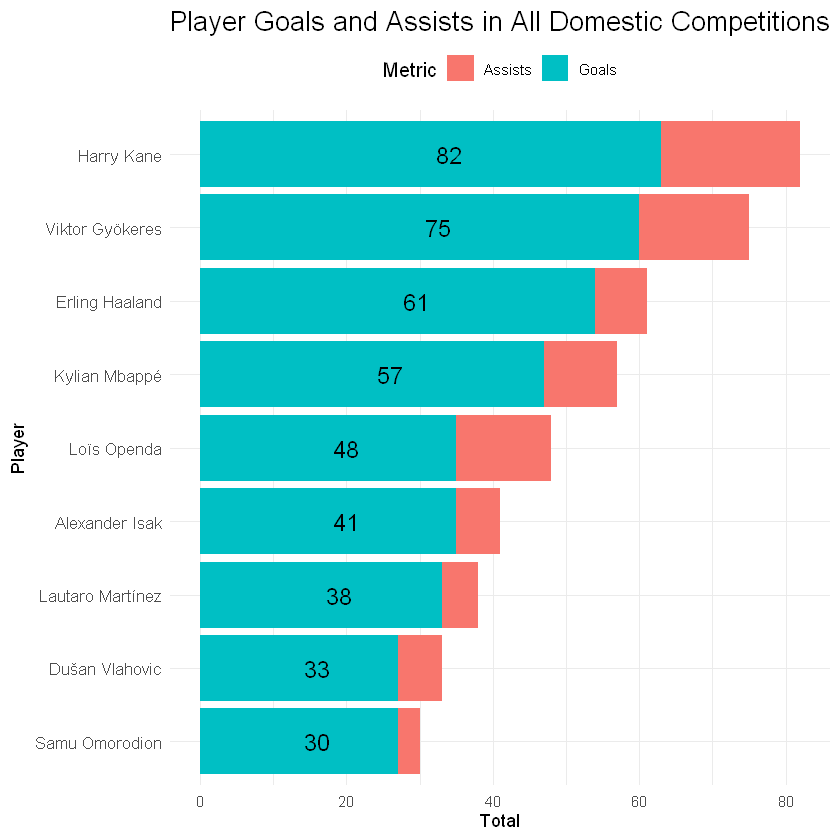

In [3]:
GA_total <- df %>%
    select(Player, Goals, Assists) %>%
    group_by(Player) %>%
    summarise(
        Goals = sum(Goals, na.rm = TRUE),
        Assists = sum(Assists, na.rm = TRUE)
    )

# Omstrukturera datan för visualisering
GA_total_long <- GA_total %>%
    pivot_longer(cols = c(Goals, Assists), names_to = "Metric", values_to = "Count") %>%
    mutate(Player = fct_reorder(Player, Count))

# Summera totalen för varje spelare
GA_total_long <- GA_total_long %>%
    group_by(Player) %>%
    mutate(Total = sum(Count))

ggplot(GA_total_long, aes(x = Count, y = Player, fill = Metric)) +
    geom_bar(stat = "identity", position = "stack") +
    geom_text(
        aes(label = ifelse(Metric == "Goals", Total, "")),
        position = position_stack(vjust = 0.5),
        hjust = -0.2,
        size = 5
    ) +
    labs(
        title = "Player Goals and Assists in All Domestic Competitions",
        x = "Total",
        y = "Player",
        fill = "Metric"
    ) +
    theme_minimal() +
    theme(
        axis.text.y = element_text(size = 10),
        plot.title = element_text(hjust = 0.5, size = 16),
        legend.title = element_text(size = 12),
        legend.position = "top"
    )

## Side By Side Comparison Isak vs Gyökeres (Excluding Domestic Cups)

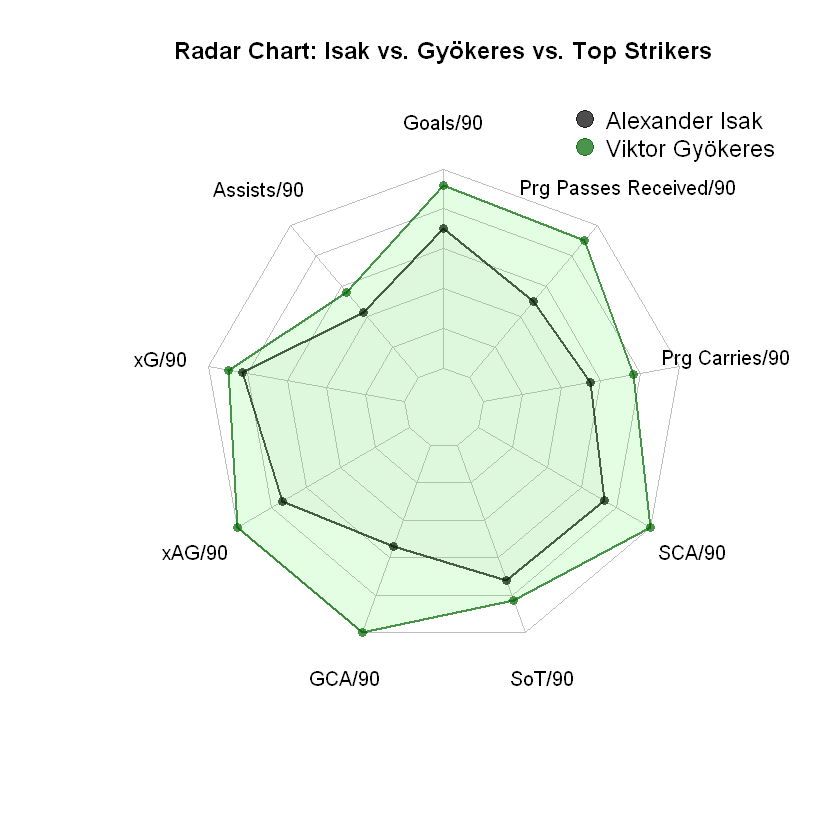

In [4]:
domestic_leagues <- c(
    "1. Premier League", "1. Bundesliga", "1. La Liga", 
    "1. Serie A", "1. Ligue 1", "1. Primeira Liga"
)

radar_stats <- df %>%
    filter(Competition %in% domestic_leagues) %>%
    group_by(Player) %>%
    summarise(
        Goals90 = mean(GoalsPer90),
        Assists90 = mean(AssistsPer90),
        xG90 = mean(xGPer90),
        xAG90 = mean(xAGPer90),
        SoT90 = mean(SoTPer90),
        SCA90 = mean(SCAPer90),
        GCA90 = mean(GCAPer90),
        PrgC90 = mean(PrgCPer90),
        PrgR90 = mean(PrgRPer90)
    )

# Manually construct the data frame for plotting, based on the values in radar_stats
## OPTIONAL: display radar_stats and its summary
#summary(radar_stats)
#radar_stats %>% filter(Player %in% c("Alexander Isak", "Viktor Gyökeres"))

comp_stats <- data.frame(
    # variable = c(max, min, Isak recorded stat, Gyökeres recorded stat)
    # max is the maximum value in each column found in radar_stats
    Goals90 = c(1.17, 0, 0.820, 1.075),
    Assists90 = c(0.385, 0, 0.165, 0.215),
    xG90 = c(0.925, 0, 0.765, 0.830),
    xAG90 = c(0.23, 0, 0.17, 0.23),
    GCA90 = c(0.77, 0, 0.415, 0.770),
    SoT90 = c(2.065, 0, 1.49, 1.71),
    SCA90 = c(4.505, 0, 3.280, 4.505),
    PrgC90 = c(4.9059, 0, 2.6736, 3.7533),
    PrgR90 = c(12.100, 0, 6.036, 10.835),
    row.names = c("max", "min", "Alexander Isak", "Viktor Gyökeres")
)

colnames(comp_stats) <- c("Goals/90", "Assists/90", "xG/90", "xAG/90", "GCA/90", "SoT/90", "SCA/90", "Prg Carries/90", "Prg Passes Received/90")

# Define fill colors
colors_fill <- c(
    scales::alpha("gray", 0.1),
    scales::alpha("green", 0.1)
)

# Define line colors
colors_line <- c(
    scales::alpha("black", 0.7),
    scales::alpha("darkgreen", 0.7)
)

# Generate plot
radarchart(
    comp_stats,
    seg = 5,
    title = "Radar Chart: Isak vs. Gyökeres vs. Top Strikers",
    pcol = colors_line,
    pfcol = colors_fill,
    plty = "solid",
    plwd = 2,
    cglty = "solid",
    cglcol = "gray"
 
)

# Legend
legend(
    x = 0.5,
    y = 1.33,
    legend = rownames(comp_stats[-c(1, 2), ]),
    bty = "n", pch = 20, col = colors_line, cex = 1.2, pt.cex = 3
)

## Over- or Underperforming?

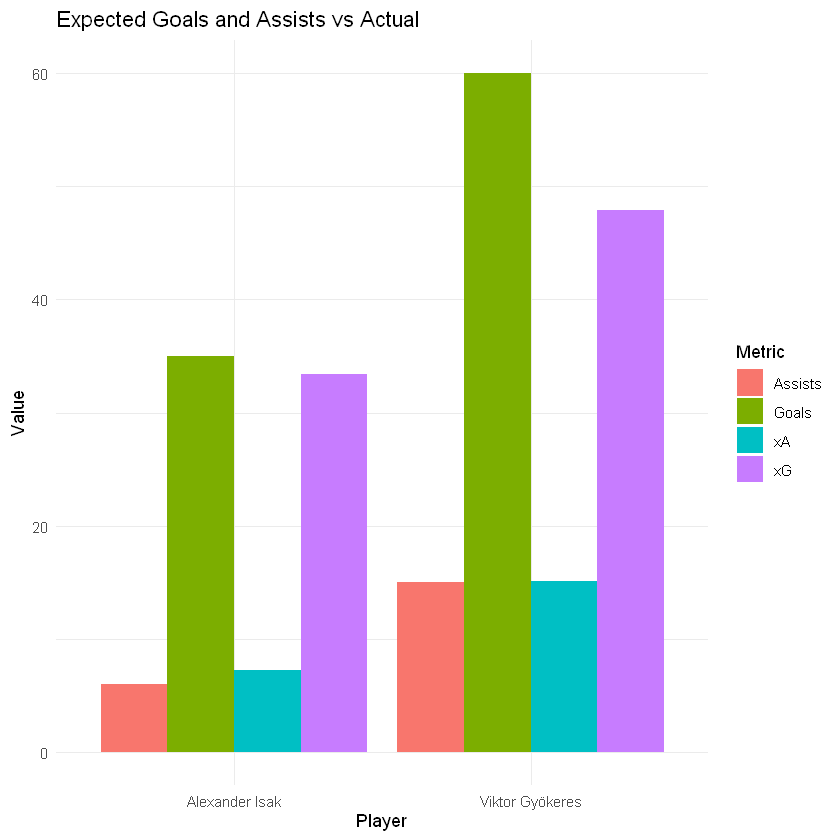

In [5]:
xg_data <- df %>%
    filter(Player %in% c("Alexander Isak", "Viktor Gyökeres")) %>%
    group_by(Player) %>%
    summarise(
        Goals = sum(Goals),
        xG = sum(xG),
        Assists = sum(Assists),
        xA = sum(xAG)
    ) %>%
    pivot_longer(cols = -Player, names_to = "Metric", values_to = "Value")

ggplot(xg_data, aes(x = Player, y = Value, fill = Metric)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(
        title = "Expected Goals and Assists vs Actual",
        x = "Player",
        y = "Value",
        fill = "Metric"
    ) +
    theme_minimal()

## Goal Conversion Rate

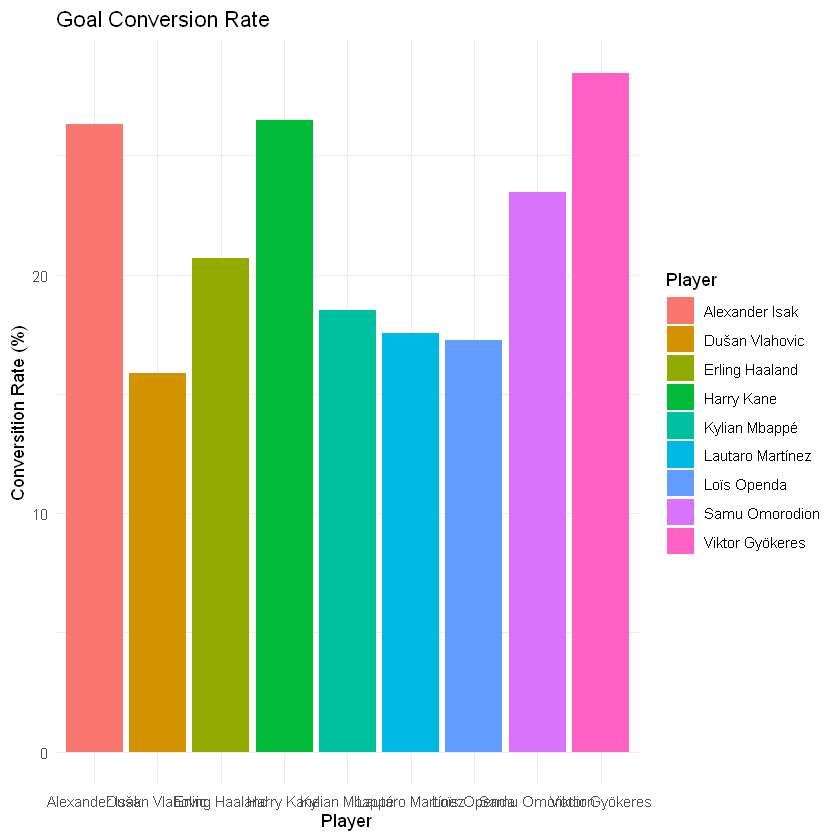

In [8]:
conversiton_rate <- df %>%
    group_by(Player) %>%
    summarise(
        TotalGoals = sum(Goals),
        TotalShots = sum(Shots),
        ConversionRate = (TotalGoals / TotalShots) * 100
    )

ggplot(conversiton_rate, aes(x = Player, y = ConversionRate, fill = Player)) +
    geom_bar(stat = "identity") +
    labs(
        title = "Goal Conversion Rate",
        x = "Player",
        y = "Conversition Rate (%)",
        fill = "Player"
    ) +
    theme_minimal()